In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
import IPython
import cv2
from os.path import abspath
from os.path import join as p_join
from pathlib import Path 
import os
import scipy
import librosa
import librosa.display

import matplotlib
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['image.cmap'] = 'gray'
data_fpath = p_join(abspath(''), 'data')
print(data_fpath)

C:\Users\Theresa\Documents\CS_Master\EPFL\CM\Project\AudioImagers\data


In [2]:
# we will need some real-world audio for some examples. 
from IPython.display import Audio
from scipy.io import wavfile

# Brandenburg concerto #1, mono, 8 kHz
audio_sample_sf, audio_sample = wavfile.read(p_join(data_fpath, "brand1.wav"))
audio_sample = audio_sample / 32767.0
print("duration:", len(audio_sample), "sample rate:", audio_sample_sf, "length=", len(audio_sample)/audio_sample_sf)
Audio(audio_sample, rate=audio_sample_sf)

duration: 63923 sample rate: 8000 length= 7.990375


functions for transforming image 

In [3]:
import scipy.interpolate as interpolate
from scipy import optimize


def sharpen_from_kernel_center(center, im):
    # creates a sharpening kernel with the given center magnitude that defines the degree of sharpening/blurring
    other = -(center-1)/8
    kernel = np.array([[other,other,other], [other,center,other], [other,other,other]])
    img = cv2.filter2D(im, -1, kernel)
    return img


def change_laplacian(im, target_value, plot=False):
    """
    reads image, manipulates sharpness and writes again to temporary file
    """
    # do not change if target is 0 bc then the feature is not relevant
    if target_value == 0:
        return im
    # read the (temporary) image that is to be manipulated
    #im = cv2.imread(image_path)

    # calculate the current laplacian value
    lap = cv2.Laplacian(im, -1, ksize=1)
    before = lap.var()

    # the amount of change in the laplacian depends on the kernel magnitude (-> the value at the center of the kernel)
    # we can model the laplacian as a function of this center value.
    # this function is mostly quadratic -> compute sharpness values for a few center values and interpolate with quadratic/cubic function
    # then find the center value that corresponds to the desired sharpness according to the interpolation
    vars = []
    # use 5 values for the interpolation
    interpolation_space = np.linspace(0,5,5)
    for c in interpolation_space:
        # sharpen/blur (center<1?) image with kernel with given center. 
        img = sharpen_from_kernel_center(c, im)
        # compute laplacian of modified image
        v = cv2.Laplacian(img, -1, ksize=1).var()
        vars += [v]
    # interpolate (center, laplacian) pairs
    interp_fn = interpolate.interp1d(interpolation_space,vars,kind='cubic', fill_value='extrapolate')
    # subtract target_value so that the 0 crossing corresponds to the desired value
    interp_fn2 = lambda x: (interp_fn(x)-target_value)


    # if the desired laplacian is not reachable, use the smallest possible
    if target_value <= interp_fn(0):
        center = 0
    # else find the kernel center that comes closest to the desired laplacian by finding 0-crossing
    else :
        center = optimize.newton(interp_fn2, 3, tol=10**(-10))
    
    
    print(im.shape)
    # sharpen image with found center
    im = sharpen_from_kernel_center(center, im)

    print(im.shape)
    return im

In [4]:
def change_hsv(im, target_values, change_hue=False):
    """
    reads image, manipulates HSV channels and writes back to file
    """
    #im = cv2.imread(image_path, cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
    # current HSV values of image
    HSV = np.mean(np.mean(im, axis = 1), axis=0)
    difference = target_values - HSV

    # we do not always want to modify the hue because the overlapping with RGB is very strong and hue is angular so the mean of hues is not very meaningful
    # we only change the hue if RGB are not changed
    if change_hue:
        start = 0
    else: 
        start = 1

    for i in range(start, 3):
        # do not change if target value is 0 bc then the feature is not relevant
        if target_values[i]==0:
            continue
        # difference image for cv2.subtract/add
        diff = np.zeros_like(im)
        # fill with the magnitude of the difference between the means
        diff[:,:,i] = abs(difference[i])
        # if difference is negative we need to decrease the mean of the channel i
        if difference[i] < 0:
            im = cv2.subtract(im, diff)
        # if positive we need to increase it
        else:
            im = cv2.add(im, diff)
    # write the resulting image back to the file
    im = cv2.cvtColor(im, cv2.COLOR_HSV2RGB)
    return im

In [21]:
def change_rgb(im, target_values):
    """
    reads image, manipulates bgr channels and writes back to file
    """
    #im = cv2.imread(image_path)
    
    # current BGR values of image
    RGB = np.mean(np.mean(im, axis = 1), axis=0)
    difference = target_values - RGB
    for i in range(3):
        # do not change if target value is 0 bc that means that the feature is not relevant
        if target_values[i] == 0:
            continue
        # difference image for cv2.subtract/add
        diff = np.zeros_like(im)
        # fill with the magnitude of the difference between the means
        diff[:,:,i] = abs(difference[i])
        # if difference is negative we need to decrease the mean of the channel i
        if difference[i] < 0:
            im = cv2.subtract(im, diff)
        # if positive we need to increase it
        else:
            im = cv2.add(im, diff)
    # write the resulting image back to the file
    #cv2.imwrite(image_path, im)
    return im

In [6]:
def transform_image(target_values, im):
    im_new = im.copy()
    # change feature values to mean values of target emotion
    im_new = change_rgb(im_new, target_values[['red', 'green', 'blue']].values[0])
    if np.all(target_values[['red', 'green', 'blue']].values[0]==0):
        im_new = change_hsv(im_new, target_values[['hue', 'saturation', 'brightness']].values[0], change_hue=True)
    else:
        im_new = change_hsv(im_new, target_values[['hue', 'saturation', 'brightness']].values[0], change_hue=False)

    im_new = change_laplacian(im_new, target_values['sharpness'].values)
    return im_new

Read test image

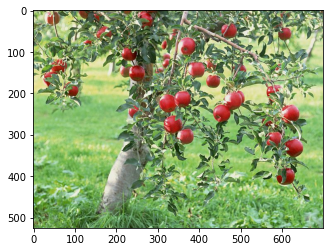

In [7]:
import pandas as pd
image_path = p_join(data_fpath, "apples.jpg")

im = cv2.imread(image_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

transform with random values

[222. 117.  10.]
mean RGB before [134.59251700680272, 157.93769523809524, 102.53281088435374]
mean RGB after [212.54266394557823, 117.75204081632653, 23.85185850340136]


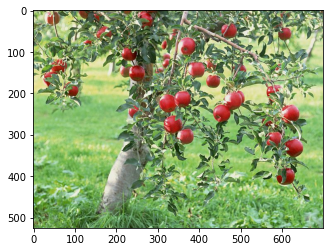

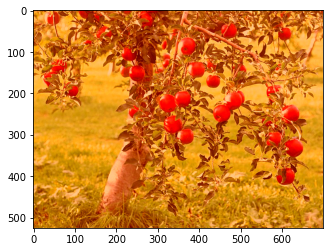

In [8]:
import pandas as pd
image_path = p_join(data_fpath, "apples.jpg")

im = cv2.imread(image_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

target_values = {'hue': 0, 'saturation': 0, 'brightness':0, 'red': 222, 'blue': 10, 'green': 117, 'sharpness': 0}
df = pd.DataFrame()
df = df.append(target_values, ignore_index=True)


im_new = transform_image(df, im)
print("mean RGB before", [np.mean(im[:,:,i]) for i in range(3)])
print("mean RGB after", [np.mean(im_new[:,:,i]) for i in range(3)])
plt.imshow(im)
plt.show()
plt.imshow(im_new)

example mapping: map change in amplitude to change in RGB values

1. bin frequencies of sample into 3 bins (low, middle, high frequencies)
2. compute the mean amplitude of each bin
3. compute mean RGB values of image
4. ratio of new amplitudes to old amplitudes defines ratio of new RGB to old RGB
5. change image accordingly

repeat over 10 disjoint time samples of the audio

In [11]:
def get_bins(sample, audio_sample_sf, num_bins):
    fmax = audio_sample_sf / 2
    N = int(len(sample) * fmax / audio_sample_sf)
    X = np.abs(np.fft.fft(sample)[0:N])
    bin_size = int(len(X)/num_bins)
    # bin the frequencies into three channels (low, middle, high frequencies) and compute average amplitude for each bin
    binned_freq = np.array([np.mean(X[i*bin_size : (i+1)*bin_size]) for i in range(num_bins)])
    return binned_freq

In [23]:
def sound_to_image(audio_sample, audio_sample_sf, image_path, num_time_bins = 10, mode="maximum", window_size=100):
    """
    mode:
    maximum = map the whole amplitude range to the whole color range
    window = map the whole amplitude range to a color range of size window_size
    """
    fmax = audio_sample_sf / 2
    time_bin_size = int(len(audio_sample)/num_time_bins)
    widths = np.linspace(0,num_time_bins*0.04,num_time_bins)
    fig,ax = plt.subplots()
    
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    mean_rgb = np.array([np.mean(im[:,:,i]) for i in range(3)])
    r = [mean_rgb[0]]
    g = [mean_rgb[1]]
    b = [mean_rgb[2]]
    im_prev = im

    # first sample
    sample = audio_sample[:time_bin_size]
    num_bins = 3
    binned_freq_prev = get_bins(sample, audio_sample_sf, num_bins)
    
    # just for plotting
    low = [binned_freq_prev[0]]
    mid = [binned_freq_prev[1]]
    high = [binned_freq_prev[2]]
    
    # find maximum amplitude of first sample to get upper bound for the mapping
    max_ampl = (255 * binned_freq_prev) / mean_rgb
    print("maximum amplitude", max_ampl, "(==255 in rgb)")
    # window
    if mode=="window":
        lower, upper = get_bounds(mean_rgb, binned_freq_prev, max_ampl, window_size)
        print("range:", lower, " to ", upper)
    else:
        lower = 0
        upper = 0

    print("initial RGB", mean_rgb)
    print("initial amplitude", binned_freq_prev)
    
    ax.bar(np.arange(num_bins)+widths[0], binned_freq_prev, width=0.051)
    ax.set_xticks(np.arange(num_bins))
    ax.set_xticklabels(((np.arange(1,num_bins+1)/num_bins)*fmax).astype(int), rotation=65)

    # loop over samples (make them overlapping?)
    for i in range(1,num_time_bins):
        sample = audio_sample[i*time_bin_size:(i+1)*time_bin_size]

        binned_freq_curr = get_bins(sample, audio_sample_sf, num_bins)
        print("amplitude", binned_freq_curr)

        low += [binned_freq_curr[0]]
        mid += [binned_freq_curr[1]]
        high += [binned_freq_curr[2]]

        fig2,ax2 = plt.subplots(1,2)
        ax.bar(np.arange(num_bins)+widths[i], binned_freq_curr, width=0.051)
        ax.set_xticks(np.arange(num_bins))
        ax.set_xticklabels(((np.arange(1,num_bins+1)/num_bins)*fmax).astype(int), rotation=65)

        # modify image accordingly
        # compute RGB values of previous image
        prev_values = np.array([np.mean(im_prev[:,:,i]) for i in range(3)])
        # change according to change in frequency 
        # ratio of frequencies = ratio of colors
        if mode == "maximum":
            # ration of frequency to max frequency = ratio of color to max color
            new_values = (255 * binned_freq_curr) / max_ampl
        # get new values in given range (not from 0 to 255 but lower to upper which is a span of "color_range")
        else:
            new_values = get_new_rgb_from_range(lower, upper, max_ampl, binned_freq_curr)
        #new_values = ((prev_values) * binned_freq_curr)/(binned_freq_prev) # (255 * binned_freq_curr) / max_ampl #(prev_values * binned_freq_curr)/binned_freq_prev
        
        r += [new_values[0]]
        g += [new_values[1]]
        b += [new_values[2]]
        print("target RGB: ",new_values)
        target_values = {'hue': 0, 'saturation': 0, 'brightness':0, 'red': new_values[0], 'green': new_values[1], 'blue': new_values[2], 'sharpness': 0}

        df = pd.DataFrame()
        df = df.append(target_values, ignore_index=True)
        im_new = transform_image(df, im)
        old_means = [np.mean(im_prev[:,:,i]) for i in range(3)]
        new_means = [np.mean(im_new[:,:,i]) for i in range(3)]

        ax2[0].imshow(im_prev)
        ax2[1].imshow(im_new)

        print("old means BGR", [np.mean(im_prev[:,:,i]) for i in range(3)])
        print("new means BGR", [np.mean(im_new[:,:,i]) for i in range(3)], "\n")

        #binned_freq_prev = binned_freq_curr
        im_prev = im_new

    ax.set_title("frequency binned vs mean amplitude. colors=time snippets")
    ax.set_xlabel("frequency")
    ax.set_ylabel("mean amplitude")
    fig.tight_layout()
    plt.show()
    return r,g,b,low,mid,high

For a linear mapping we first have to define the range of amplitudes that we want to be able to map since the color range is fixed to $[0,255]$.
With the first sound sample we get the first three amplitudes (average amplitude of binned low, mid and high frequencies) and the initial mean RGB values from the image. We know that we want to map these amplitudes to these RGBs but how do we know to which RGBs we map a new amplitude? To do this, we first have to "calibrate" the linear mapping that will translate the amplitude to a color. 

Let's focus on the red channel and the low frequencies for now, since we should define a different mapping for each color channel anyhow. We know that the red values are in a fixed range $[0,255]$. For the amplitude we know the lower bound, 0, but not the upper. But we know another pair: the given initial amplitude and red value $(a_R, R)$. With these two points $(0,0)$ and $(a_R, R)$. we can define a linear mapping. There are several ways to get this mapping, we will do it by finding the maximum amplitude first:

$\frac{a_R}{R} = \frac{a_{max}}{255} \to a_{max} = \frac{255 \cdot a_R}{R}$

We use this to transfer a new amplitude $a_R'$ from the range $[0,a_{max}]$ to $[0,255]$ ot get the corresponding red value $R'$:

$R' = \frac{a'_R \cdot 255}{a_{max}}$


maximum amplitude [15.25232081  3.63381821  2.21174104] (==255 in rgb)
initial RGB [134.59251701 157.93769524 102.53281088]
initial amplitude [8.05038529 2.2506544  0.88931775]
amplitude [11.08001509  4.39968337  1.77710789]
target RGB:  [185.24419217 308.74391536 204.88949842]
old means BGR [134.59251700680272, 157.93769523809524, 102.53281088435374]
new means BGR [181.8435755102041, 248.5103619047619, 200.19403537414965] 

amplitude [16.83636701  5.41514095  2.04368898]
target RGB:  [281.48329959 380.00275875 235.62464184]
old means BGR [181.8435755102041, 248.5103619047619, 200.19403537414965]
new means BGR [244.65088979591837, 254.87212517006802, 224.73577414965987] 

amplitude [19.37688052  5.04765948  1.66843378]
target RGB:  [323.95755342 354.21506927 192.36004827]
old means BGR [244.65088979591837, 254.87212517006802, 224.73577414965987]
new means BGR [253.37514285714286, 254.03605986394558, 188.65501224489796] 

amplitude [17.02642626  3.89156651  1.11104339]
target RGB:  [284

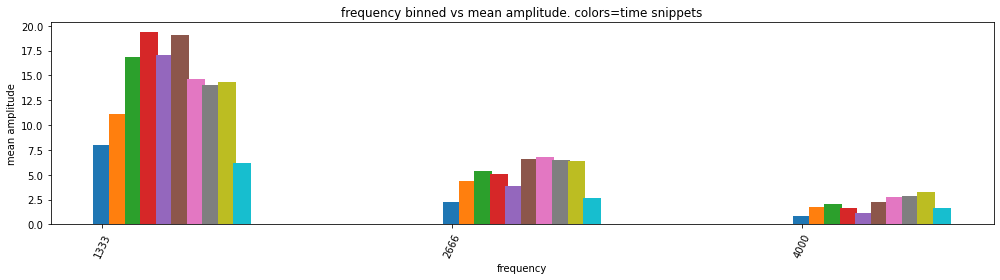

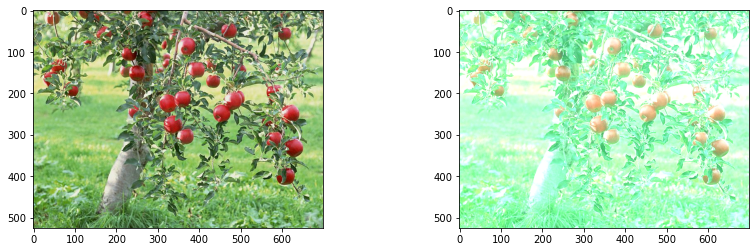

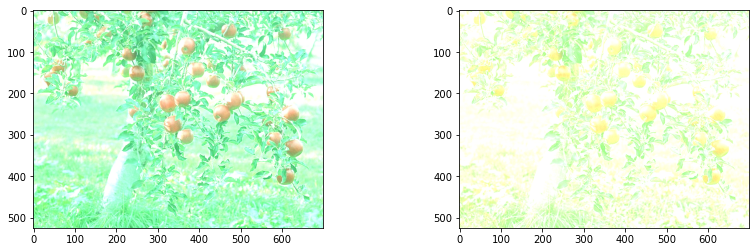

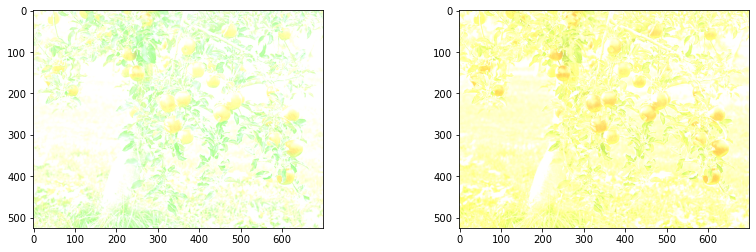

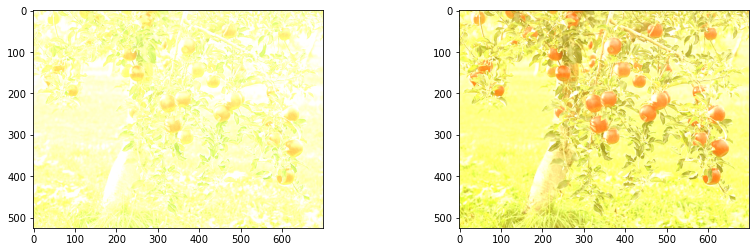

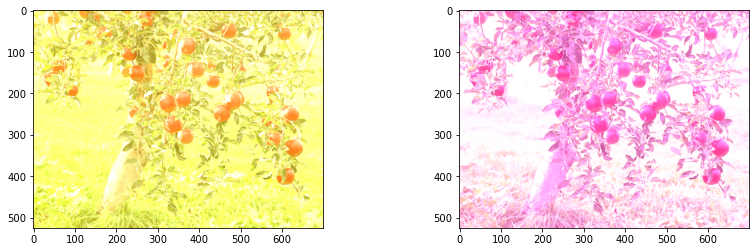

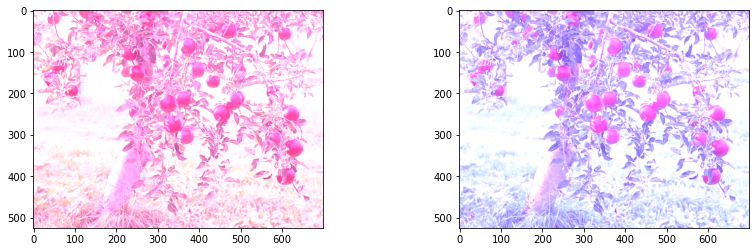

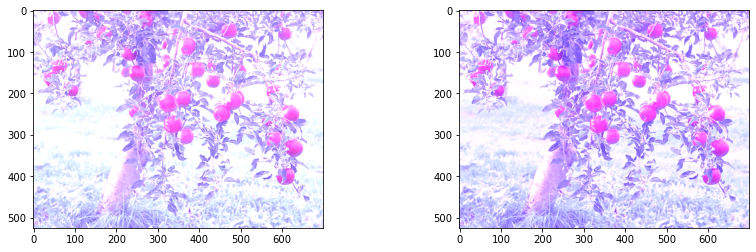

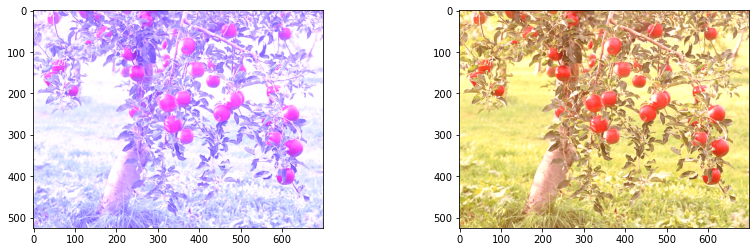

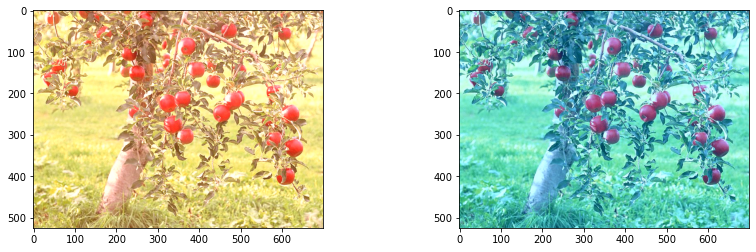

In [24]:
num_time_bins = 10
r,g,b, low,mid,high = sound_to_image(audio_sample, audio_sample_sf, image_path, num_time_bins, mode="maximum", window_size=50)

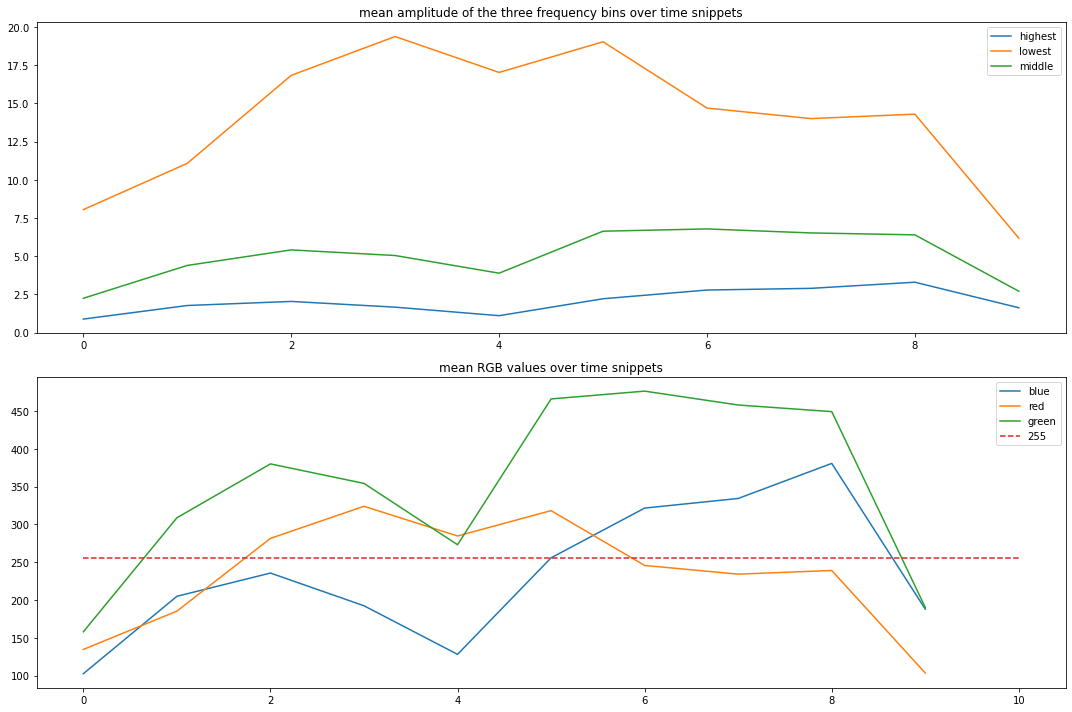

In [25]:
fig, ax = plt.subplots(2,1, figsize=(15,10))
ax[1].plot(np.arange(num_time_bins), b, label="blue")
ax[1].plot(np.arange(num_time_bins), r, label="red")
ax[1].plot(np.arange(num_time_bins), g, label="green")
ax[1].plot([0,num_time_bins], [255,255], "--", label="255")
ax[1].legend()
ax[1].set_title("mean RGB values over time snippets")
ax[0].plot(np.arange(num_time_bins), high, label="highest")
ax[0].plot(np.arange(num_time_bins), low, label="lowest")
ax[0].plot(np.arange(num_time_bins), mid, label="middle")
ax[0].legend()
ax[0].set_title("mean amplitude of the three frequency bins over time snippets")
fig.tight_layout()


However, if $a_R' > a_{max}$ we will get a value that is larger than 255. And indeed, we see that very often the computed RGB values exceed 255 and the image saturates. Because we do not know the biggest amplitude value we will see in all sound samples we cannot find a linear mapping that never exceeds 255.

But we can try to make smaller changes to the RGB so that the chance that the image saturates is lower. One way to do this is to map the whole amplitude range not to the whole color range but to a smaller range around the RGB values of the intial image.
In the previous mapping we have mapped the amplitude value 0 to color value 0 and amplitude max_ampl to 255. When the new amplitude extends the max amplitude, we exceed the color range. Instead we now map the amplitude range $[0,a_{max}]$ to to a color range [upper, lower] such that the ratio $\frac{a_{max}-0}{a_R-0}$ is preserved in $\frac{upper-lower}{R-lower}$.

We calculate lower and upper like this:

$lower = f(0) = R - (\frac{a_R}{a_{max}} \cdot color\_range)$ </br>
$upper = f(a_{max}) = R + (1 - \frac{a_R}{a_{max}}) \cdot color\_range$

f is then defined as:

$f(a) = \frac{a}{a_{max}} \cdot (upper - lower) + lower$

If we now get a high amplitude and exceed the range [lower, upper] a bit, it is not such a big problem because we still get some valid ($\leq 255$) values. (It can still happen however. We have to adapt the window size then)

In [27]:
def get_bounds(initial_rgb, initial_ampl, max_ampl, color_range):
    lower = initial_rgb - ((initial_ampl/max_ampl) * color_range)
    upper = initial_rgb + ( (1-(initial_ampl/max_ampl)) * color_range)
    return lower, upper

In [28]:
def get_new_rgb_from_range(lower, upper, max_ampl, ampl):
    return (ampl/max_ampl) * (upper-lower) + lower

define a range for RGB value changes that corresponds to the range of possible amplitudes (0, max_ampl).
ex. range = 50 for a given max_ampl and initial amplitudes and initial RGB value. Then the range of values we can achieve is:

lower = initial RGB - (initial amplitudes/max_ampl) $\cdot $ 50 </br>
upper = initial RGB + (1 - initial amplitudes/max_ampl) $\cdot $ 50

Given a new amplitude $a$ from a new sound sample we can calculate the corresponding change in RGB with:

$\frac{a}{max\_ampl} \cdot (upper - lower) + lower$

example

In [37]:
max_ampl = 10
initial_ampl = 3
color_range = 50
initial_rgb = 100
lower, upper = get_bounds(initial_rgb, initial_ampl, max_ampl, color_range)
print("amplitude range:", 0, "to", max_ampl)
print("initial amplitude=", initial_ampl, "should correspond to intial color value=",initial_rgb)
print("then:")
print("color range", lower, "to", upper)
print("range below current RGB:",initial_rgb-lower,"and above:", upper-initial_rgb)
print("range below current amplitude:", initial_ampl,"and above:", max_ampl-initial_ampl)
print(f"ratios are preserved: max_ampl/initial_ampl = {max_ampl/initial_ampl:.2} = {(upper-lower)/(initial_rgb-lower):.2} = range/(initial-lower). i.e. the range of amplitude values we have below the current amplitude corresponds to the range we have for the RGB values. Same for values higher than current amplitude")

new_ampl = 7.0
new_color = get_new_rgb_from_range(lower, upper, max_ampl, max_ampl)
print(f"a new amplitude of {new_ampl} maps to f({new_ampl})={new_color}")

amplitude range: 0 to 10
initial amplitude= 3 should correspond to intial color value= 100
then:
color range 85.0 to 135.0
range below current RGB: 15.0 and above: 35.0
range below current amplitude: 3 and above: 7
ratios are preserved: max_ampl/initial_ampl = 3.3 = 3.3 = range/(initial-lower). i.e. the range of amplitude values we have below the current amplitude corresponds to the range we have for the RGB values. Same for values higher than current amplitude
a new amplitude of 7.0 maps to f(7.0)=135.0


maximum amplitude [15.25232081  3.63381821  2.21174104] (==255 in rgb)
range: [ 97.64555155 114.58224949  74.38654907]  to  [167.64555155 184.58224949 144.38654907]
initial RGB [134.59251701 157.93769524 102.53281088]
initial amplitude [8.05038529 2.2506544  0.88931775]
amplitude [11.08001509  4.39968337  1.77710789]
target RGB:  [148.49689842 199.33548115 130.63072511]
old means BGR [134.59251700680272, 157.93769523809524, 102.53281088435374]
new means BGR [147.0483673469388, 196.79203537414966, 130.04180680272108] 

amplitude [16.83636701  5.41514095  2.04368898]
target RGB:  [174.91547693 218.89673228 139.0678233 ]
old means BGR [147.0483673469388, 196.79203537414966, 130.04180680272108]
new means BGR [172.91682993197279, 211.45105578231292, 137.9483074829932] 

amplitude [19.37688052  5.04765948  1.66843378]
target RGB:  [186.57507602 211.8177587  127.19126821]
old means BGR [172.91682993197279, 211.45105578231292, 137.9483074829932]
new means BGR [182.77321088435374, 206.442489795

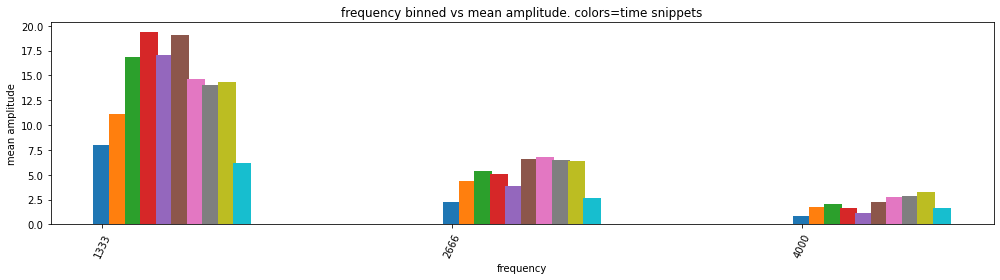

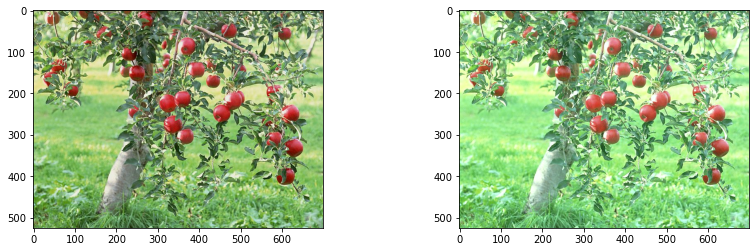

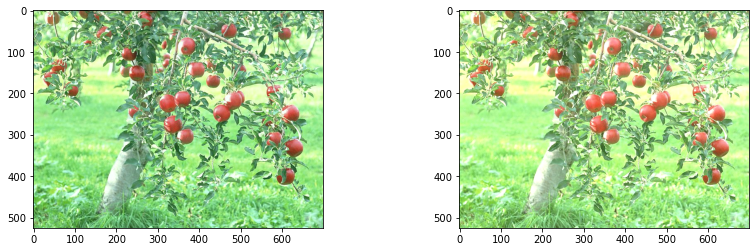

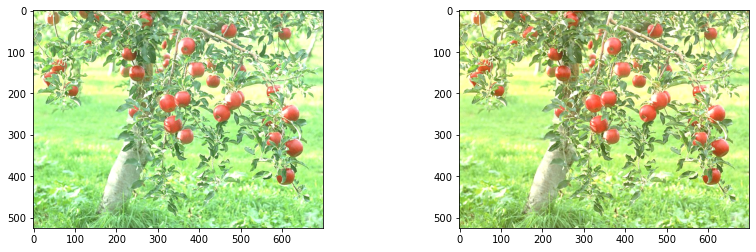

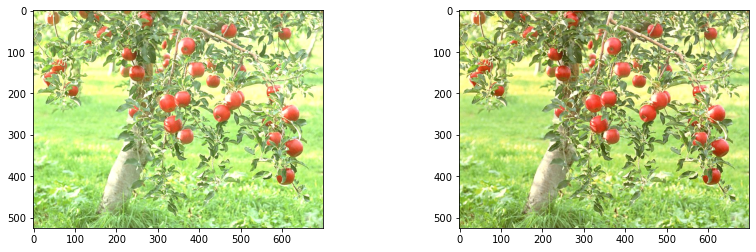

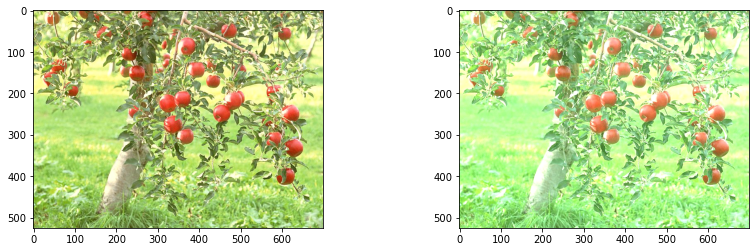

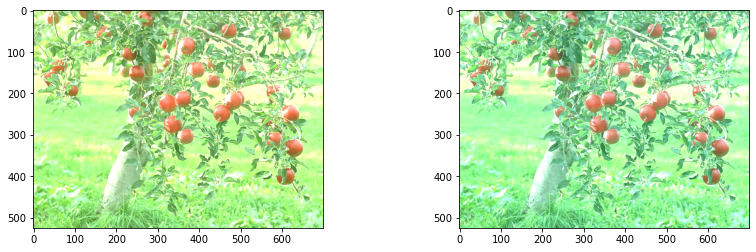

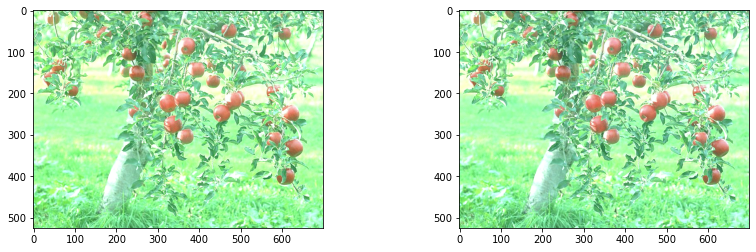

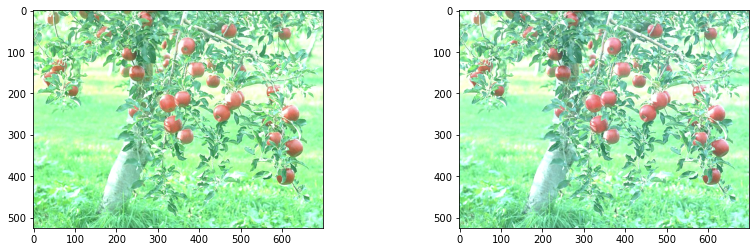

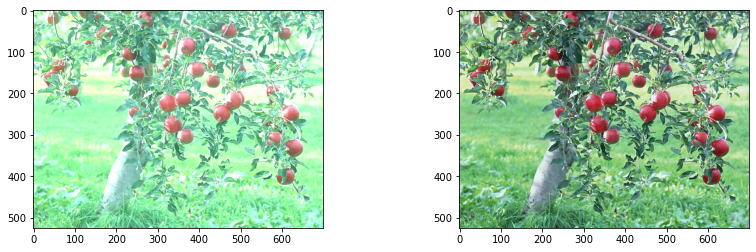

In [38]:
r,g,b, low,mid,high = sound_to_image(audio_sample, audio_sample_sf, image_path, mode="window", window_size=70)

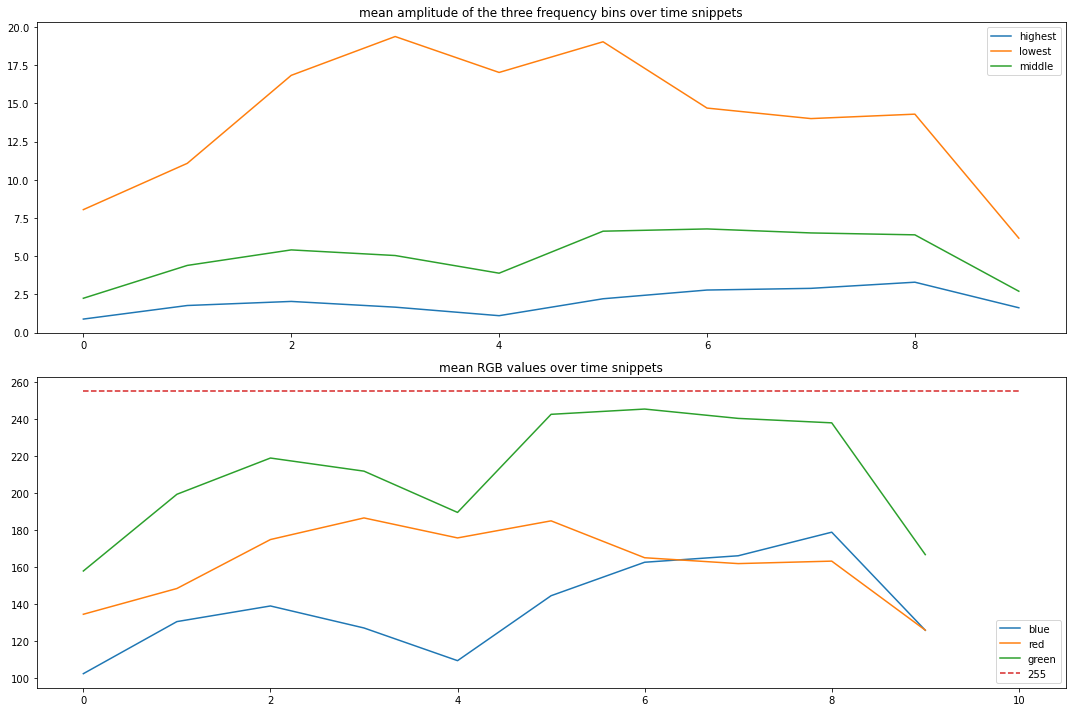

In [39]:
fig, ax = plt.subplots(2,1, figsize=(15,10))
ax[1].plot(np.arange(num_time_bins), b, label="blue")
ax[1].plot(np.arange(num_time_bins), r, label="red")
ax[1].plot(np.arange(num_time_bins), g, label="green")
ax[1].plot([0,num_time_bins], [255,255], "--", label="255")
ax[1].legend()
ax[1].set_title("mean RGB values over time snippets")
ax[0].plot(np.arange(num_time_bins), high, label="highest")
ax[0].plot(np.arange(num_time_bins), low, label="lowest")
ax[0].plot(np.arange(num_time_bins), mid, label="middle")
ax[0].legend()
ax[0].set_title("mean amplitude of the three frequency bins over time snippets")
fig.tight_layout()

Depending on the size of the window, we get values that do not exceed 255 while still seeing a decent change in the image.
With 50 we see only a small change, with 100 the channels sometimes saturate and with 70 we get a nice transition.